In [70]:
from pathlib import Path
import pandas as pd
from dfply import *
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import io
import requests
import statsmodels.api as sm
import datetime

In [3]:
%load_ext autoreload
%autoreload 2
pd.set_option('max_rows', 1000)
pd.set_option('max_columns', 1000)

In [4]:
data_dir_path = Path('data')

## データの取得

https://www.mizuhobank.co.jp/market/historical.html

In [4]:
m_quote_data = pd.read_csv(
    data_dir_path.joinpath('m_quote.csv'),
    encoding='shift_jis'
)

In [31]:
url = 'https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv'

In [32]:
air_passengers = requests.get(url).content
air_passengers = pd.read_csv(io.StringIO(air_passengers.decode('utf-8')))

In [5]:
colnames = m_quote_data.loc[0, :].values.tolist()
colnames[0] = 'day'
m_quote_data.columns = colnames
m_quote_data = m_quote_data.loc[1:len(m_quote_data), :].copy()
m_quote_data.reset_index(inplace=True, drop=True)

In [6]:
m_quote_data.head()

,day,USD,GBP,EUR,CAD,CHF,SEK,DKK,NOK,AUD,NZD,ZAR,BHD,IDR(100),CNY,HKD,INR,MYR,PHP,SGD,KRW(100),THB,KWD,SAR,AED,MXN,PGK,HUF,CZK,PLN,RUB,TRY,IDR(100),CNY,MYR,KRW(100),TWD
0,2002/4/30,131.15,189.01,115.97,82.83,79.13,12.73,15.61,15.2,70.24,58.08,11.83,348.32,*****,*****,16.82,2.69,*****,2.58,71.64,9.99,3.02,429.5,34.98,35.71,14.36,*****,*****,*****,*****,NaN,NaN,1.39,15.84,*****,9.99,3.77
1,2002/5/31,126.44,184.56,115.88,81.58,79.6,12.57,15.59,15.43,69.58,58.38,12.51,335.97,*****,*****,16.21,2.6,*****,2.54,70.23,10.1,2.96,417.48,33.73,34.43,13.3,*****,*****,*****,*****,NaN,NaN,1.41,15.28,*****,10.1,3.68
2,2002/6/28,123.53,183,117.83,80.64,80.09,12.94,15.86,15.92,70.29,60.48,12.22,328.37,*****,*****,15.84,2.54,*****,2.46,69.27,10.2,2.93,410.12,32.96,33.64,12.67,*****,*****,*****,*****,NaN,NaN,1.44,14.93,*****,10.2,3.66
3,2002/7/31,118.05,183.64,117.23,76.52,80.16,12.67,15.79,15.83,65.42,56.82,11.73,313.77,*****,*****,15.13,2.43,*****,2.34,67.35,9.98,2.86,393.79,31.49,32.15,12.07,*****,*****,*****,*****,NaN,NaN,1.34,14.26,*****,9.98,3.56
4,2002/8/30,119.08,183.14,116.45,75.85,79.6,12.59,15.69,15.68,64.47,55.28,11.31,316.39,*****,*****,15.27,2.46,*****,2.31,67.82,9.97,2.83,396.92,31.77,32.43,12.12,*****,*****,*****,*****,NaN,NaN,1.35,14.39,*****,9.97,3.53


In [16]:
m_quote_data['USD'] = m_quote_data['USD'].astype(float)

https://www.e-stat.go.jp/dbview?sid=0003343671

In [62]:
icecream_data = pd.read_csv(
    data_dir_path.joinpath('icecream.csv'),
    encoding='shift_jis'
)

## データの加工

In [63]:
icecream_data = icecream_data.loc[
    :, np.array(icecream_data.columns.tolist())[[3, 5]]
]

icecream_data.columns = ['date', 'expenditure']
dates = icecream_data['date'].apply(
    lambda x: datetime.datetime.strptime(x, '%Y年%m月')
)
icecream_data['year'] = dates.apply(lambda x: x.strftime('%Y')).astype(int)
icecream_data['month'] = dates.apply(lambda x: x.strftime('%m')).astype(int)
icecream_data['number'] = icecream_data.index
icecream_data['expenditure'] = icecream_data['expenditure'].astype(int)

## データの確認

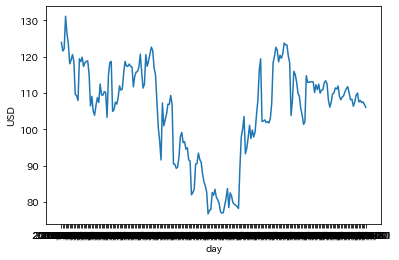

In [17]:
sns.lineplot(
    data=m_quote_data,
    x='day',
    y='USD'
)

<AxesSubplot:xlabel='number', ylabel='expenditure'>

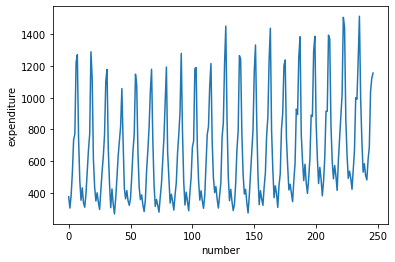

In [54]:
sns.lineplot(
    data=icecream_data,
    x='number',
    y='expenditure'
)

## 季節調整

In [64]:
icecream_data['cma'] = icecream_data.expenditure.rolling(
    window=12
).mean().shift(-6)
icecream_data['cma'] = icecream_data.cma.rolling(window=2).mean()

<AxesSubplot:xlabel='number', ylabel='expenditure'>

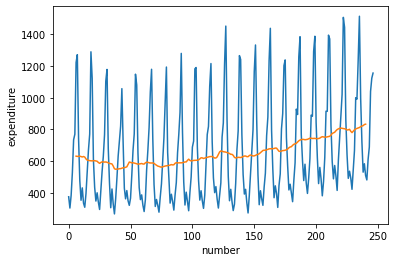

In [65]:
sns.lineplot(
    data=icecream_data,
    x='number',
    y='expenditure'
)
sns.lineplot(
    data=icecream_data,
    x='number',
    y='cma'
)

In [83]:
seasonal_adjustment = icecream_data >> filter_by(
    X.cma.notna()
) >> mutate(
    expenditure_div_cma=X.expenditure/X.cma
)

In [95]:
seasonal_indexes = seasonal_adjustment >> group_by(
    X.month
) >> summarise(
    count_=X.month.count(),
    value=X.expenditure_div_cma.sum()
) 

seasonal_indexes = seasonal_adjustment >> group_by(
    X.month
) >> summarise(
    count_=X.month.count(),
    value=X.expenditure_div_cma.sum()
) >> mutate(
    value=X.value/X.count_
) >> ungroup >> mutate(
    seasonal_index=X.value*1200/X.value.sum()
)

<AxesSubplot:xlabel='month', ylabel='seasonal_index'>

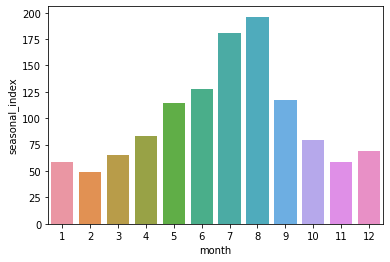

In [96]:
sns.barplot(
    data=seasonal_indexes,
    x='month',
    y='seasonal_index'
)

In [97]:
seasonal_adjustment = icecream_data >> left_join(
    seasonal_indexes >> select(
        X.month, X.seasonal_index
    ),
    by='month'
) >> mutate(
    adjustmented_series=X.expenditure*100/X.seasonal_index
)

<AxesSubplot:xlabel='number', ylabel='expenditure'>

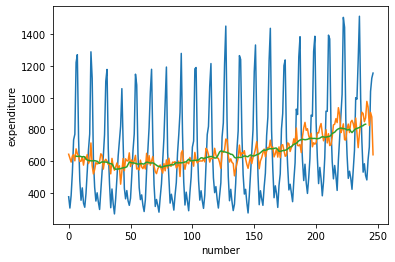

In [101]:
sns.lineplot(
    data=seasonal_adjustment,
    x='number',
    y='expenditure'
)
sns.lineplot(
    data=seasonal_adjustment,
    x='number',
    y='adjustmented_series'
)
sns.lineplot(
    data=seasonal_adjustment,
    x='number',
    y='cma'
)

## 移動平均乖離率（Moving Average Deviation Rate）

In [102]:
icecream_data = icecream_data >> mutate(
    madr=(X.expenditure-X.cma)*100/X.cma
)

<AxesSubplot:xlabel='number', ylabel='madr'>

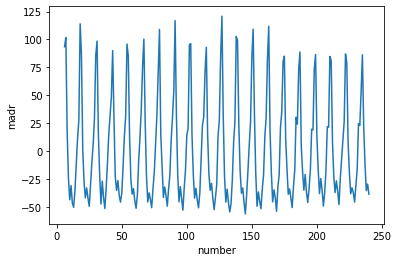

In [107]:
sns.lineplot(
    data=icecream_data,
    x='number',
    y='madr'
)

In [108]:
icecream_data['sigma'] = icecream_data.expenditure.rolling(
    window=12
).std()

<AxesSubplot:xlabel='number', ylabel='sigma'>

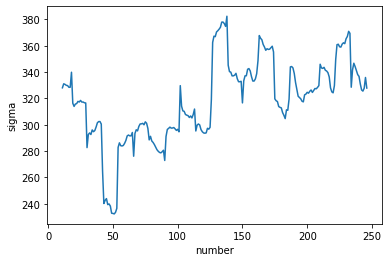

In [109]:
sns.lineplot(
    data=icecream_data,
    x='number',
    y='sigma'
)

## 正規性の検定
Shapiro-Wiki検定

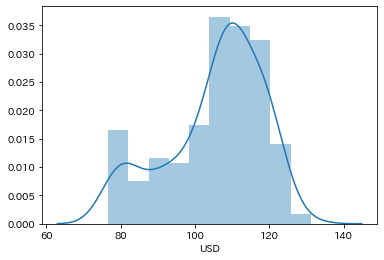

In [18]:
sns.distplot(m_quote_data['USD'])

In [19]:
usd_diff = m_quote_data['USD'].diff().dropna()

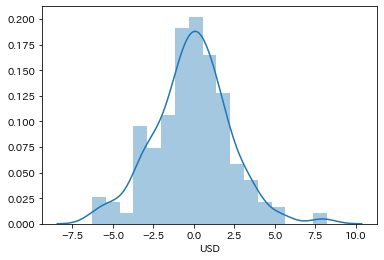

In [25]:
sns.distplot(usd_diff)

In [24]:
stats.shapiro(m_quote_data['USD'])

(0.9270657896995544, 5.287141835452758e-09)

In [23]:
stats.shapiro(usd_diff)

(0.9880411624908447, 0.06292707473039627)

### 自己相関

In [42]:
air_passengers_acf = sm.tsa.stattools.acf(air_passengers['#Passengers'])
air_passengers_acf

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


array([1.        , 0.94804734, 0.87557484, 0.80668116, 0.75262542,
       0.71376997, 0.6817336 , 0.66290439, 0.65561048, 0.67094833,
       0.70271992, 0.74324019, 0.76039504, 0.71266087, 0.64634228,
       0.58592342, 0.53795519, 0.49974753, 0.46873401, 0.44987066,
       0.4416288 , 0.45722376, 0.48248203, 0.51712699, 0.53218983,
       0.49397569, 0.43772134, 0.3876029 , 0.34802503, 0.31498388,
       0.28849682, 0.27080187, 0.26429011, 0.27679934, 0.2985215 ,
       0.32558712, 0.3370236 , 0.30333486, 0.25397708, 0.21065534,
       0.17217092])

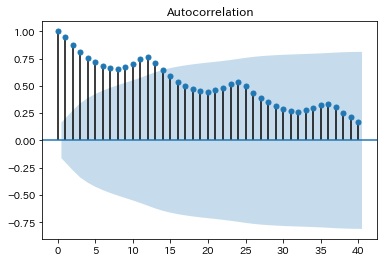

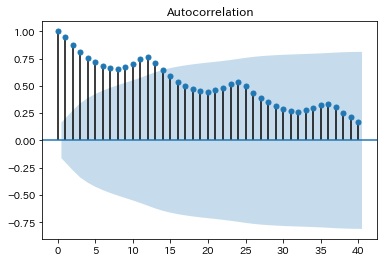

In [46]:
sm.graphics.tsa.plot_acf(air_passengers['#Passengers'], lags=40)

In [48]:
sm.tsa.stattools.pacf(air_passengers['#Passengers'], method='ols')

array([ 1.        ,  0.95893198, -0.32983096,  0.2018249 ,  0.14500798,
        0.25848232, -0.02690283,  0.20433019,  0.15607896,  0.56860841,
        0.29256358,  0.8402143 ,  0.61268285, -0.66597616, -0.38463943,
        0.0787466 , -0.02663483, -0.05805221, -0.04350748,  0.27732556,
       -0.04046447,  0.13739883,  0.3859958 ,  0.24203808, -0.04912986,
       -0.19599778, -0.15443575,  0.04484465,  0.18371541, -0.0906113 ,
       -0.06202938,  0.34827092,  0.09899499, -0.08396793,  0.36328898,
       -0.17956662,  0.15839435,  0.06376775, -0.27503705,  0.2707607 ,
        0.32002003])

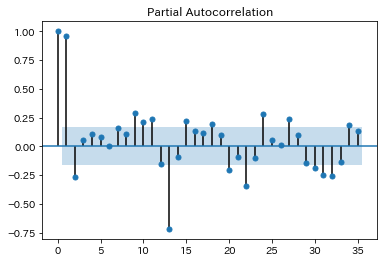

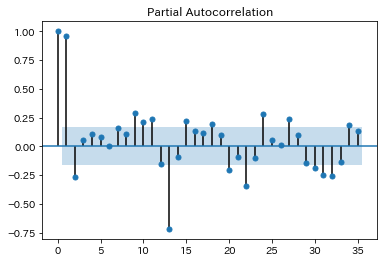

In [53]:
sm.graphics.tsa.plot_pacf(air_passengers['#Passengers'], lags=35)

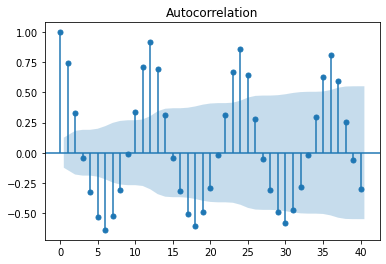

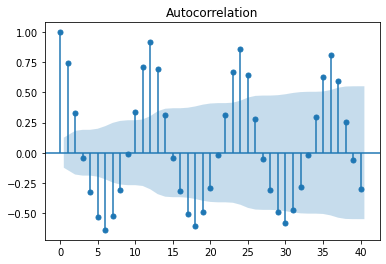

In [115]:
sm.graphics.tsa.plot_acf(icecream_data['expenditure'], lags=40)

/usr/local/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


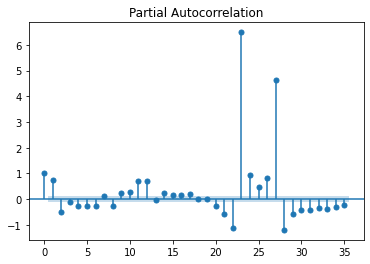

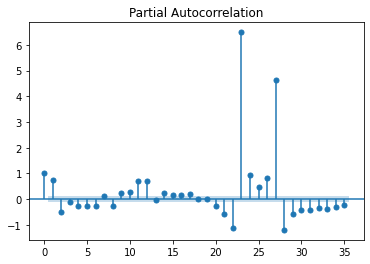

In [114]:
sm.graphics.tsa.plot_pacf(icecream_data['expenditure'], lags=35)